In [5]:
import xarray as xr
import numpy as np
from datetime import datetime
import pandas as pd
import glob
import geopandas as gpd

from matplotlib import pyplot as plt

In [6]:
ds = xr.open_dataset('/rds/general/user/cb2714/projects/wwa/ephemeral/'+
                     'cali-wildfires/era5_DC_1940-2025.nc')

gdf = gpd.read_file("sf_socal-baja/")
gdf = gdf.to_crs(crs = "EPSG:4326")
gdf = gdf[gdf.US_L3CODE == '85']
gdf = gdf[gdf.Shape_Area == gdf.Shape_Area.max()]

ds = ds.rio.write_crs("EPSG:4326")
ds = ds.rio.clip(gdf.geometry.values, gdf.crs, all_touched = True)

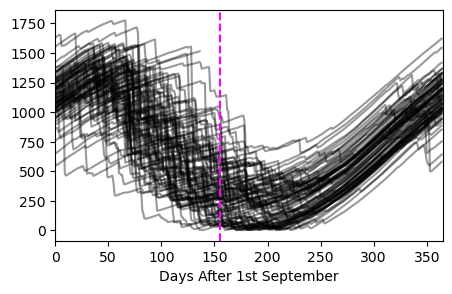

In [11]:
colours = plt.cm.inferno(np.linspace(0, 1, len(hydro_yrs)))
fig, ax = plt.subplots(1, 1, figsize = (5,3))
for i,data in enumerate(hydro_yrs):
    ax.plot(np.arange(len(data)), data.data, c = 'k', alpha = 0.4)
ax.set_xlim((0,365))
ax.set_xlabel('Days After 1st September')
ax.axvline(155, color = "magenta", ls = "--")
plt.show()

In [10]:
def hydro_days(ds):
    
    hydro_yrs = []
    for yr in range(int(ds.time.dt.year.min()), int(ds.time.dt.year.max())):
        temp = ds.DC.sel(time = np.logical_or(
            np.logical_and(ds.time.dt.year == yr, ds.time.dt.month >= 9),
            np.logical_and(ds.time.dt.year == yr+1, ds.time.dt.month <= 8)))
        temp = temp.mean(dim = ['latitude','longitude'])
        hydro_yrs.append(temp)
    
    hydro_doys = []
    for i, data in enumerate(hydro_yrs):
        temp = data.rolling(time = 7).mean()#.resample(time = 'W').mean()
        drop = list([np.nan]*7) + list(temp.data[7:] - temp.data[:-7])
        min_arg = np.nanargmin(drop)
        doy_hydro = int(temp.time[min_arg].dt.dayofyear)
        start_doy = int(data.time[0].dt.dayofyear)
        if doy_hydro >= start_doy:
            output = doy_hydro - start_doy
        else:
            eoy = pd.to_datetime(f'{int(temp.time.dt.year[0])}-12-31').dayofyear
            output = (eoy - start_doy) + doy_hydro
        hydro_doys.append(output)

    yrs = np.arange(int(ds.time.dt.year.min()), int(ds.time.dt.year.max()))
    
    df = pd.DataFrame(
        np.array([yrs, hydro_doys]).T,
        columns = ["year", "dc_doy"])
    return df

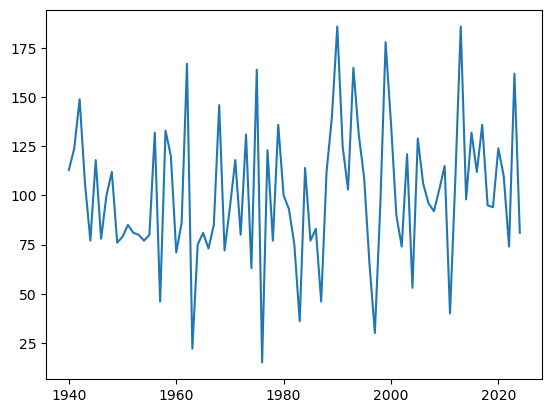

In [14]:
df = hydro_days(ds)

plt.plot(df.year, df.dc_doy)

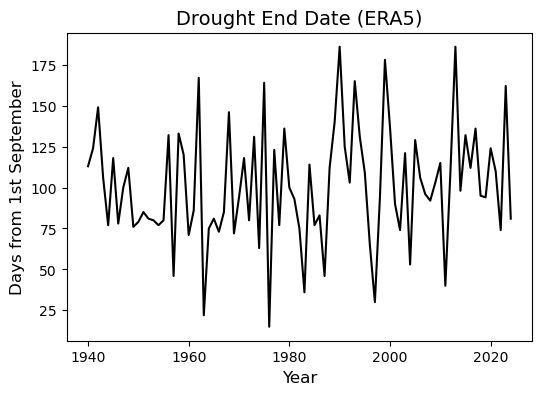

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (6,4))
ax.plot(yrs, hydro_doys, c = 'k')
ax.set_title('Drought End Date (ERA5)', fontsize = 14)
ax.set_ylabel('Days from 1st September', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)
plt.show()

In [7]:
df = pd.DataFrame(
    np.array([hydro_doys,yrs]).T,
    columns = ['biggest_DC_drop_from_1st_Sept','season_start_year'])
df.to_csv('drought_end_date.csv')

In [8]:
df

,biggest_DC_drop_from_1st_Sept,season_start_year
0,113,1940
1,124,1941
2,149,1942
3,106,1943
4,77,1944
...,...,...
80,124,2020
81,110,2021
82,74,2022
83,162,2023


# Get 